# Лабораторная работа №3.
## Шорсткая А.А. группа 3372

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import random

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_curve, auc, 
                           roc_auc_score, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'jupyterlab'

df = pd.read_csv('student_exam_scores_with_productivity_cleaned.csv')

В роли целевого класса я выбрала productivity_score, сгенерированный класс из 2 лабораторной. 

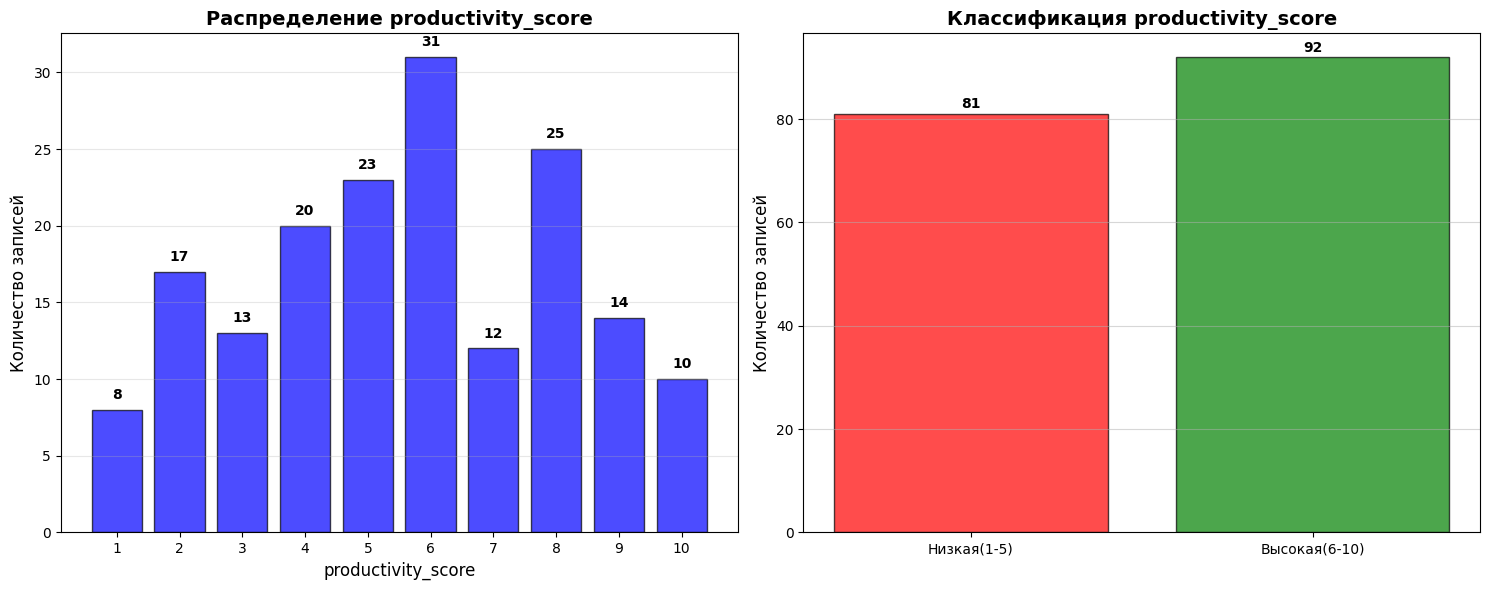

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

value_counts = df['productivity_score'].value_counts().sort_index()

bars1 = ax1.bar(value_counts.index, value_counts.values, 
               color='blue', alpha=0.7, edgecolor='black')

ax1.set_title('Распределение productivity_score', fontsize=14, fontweight='bold')
ax1.set_xlabel('productivity_score', fontsize=12)
ax1.set_ylabel('Количество записей', fontsize=12)
ax1.set_xticks(range(1, 11))
ax1.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars1, value_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

df['productivity_binary'] = (df['productivity_score'] >= 6).astype(int)
binary_counts = df['productivity_binary'].value_counts().sort_index()

binary_labels = ['Низкая(1-5)', 'Высокая(6-10)']
binary_values = [binary_counts[0], binary_counts[1]]

bars2 = ax2.bar(binary_labels, binary_values, 
               color=['red', 'green'], alpha=0.7, edgecolor='black')

ax2.set_title('Классификация productivity_score', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество записей', fontsize=12)
ax2.grid(True, alpha=0.5, axis='y')

for bar, count in zip(bars2, binary_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

На графике видно, что данный класс несбалансирован, а пик занчанией приходяться на "6". Но при этом, если разделить значения на две группы, то они получаются практически равными.

## Оценка и сравнение результатов классификации.

In [3]:
df = df.drop(['student_id'], axis=1)

X = df.drop(['productivity_score', 'productivity_binary'], axis=1)
y = df['productivity_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

### Метод ближайших соседей

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("Метод ближайших соседей:")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Метод ближайших соседей:
[[19  5]
 [ 6 22]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.81      0.79      0.80        28

    accuracy                           0.79        52
   macro avg       0.79      0.79      0.79        52
weighted avg       0.79      0.79      0.79        52



### Дерево решений

In [5]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


print("Дерево решений:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Дерево решений:
[[21  3]
 [ 4 24]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.89      0.86      0.87        28

    accuracy                           0.87        52
   macro avg       0.86      0.87      0.86        52
weighted avg       0.87      0.87      0.87        52



## Сравнение результатов двух алгоритмов

In [6]:
y_proba_knn = knn.predict_proba(X_test)[:, 1]
y_proba_dt = dt.predict_proba(X_test)[:, 1]

metrics = {
    'Алгоритм': ['Метод ближайших соседей', 'Дерево решений'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dt)
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dt)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.round(3))

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba_dt)

roc_knn = auc(fpr_knn, tpr_knn)
roc_dt = auc(fpr_dt, tpr_dt)

print(f"ROC метода ближайших соседей: {roc_knn:.3f}")
print(f"ROC дерево решений: {roc_dt:.3f}")

                  Алгоритм  Accuracy  Precision  Recall  F1-Score
0  Метод ближайших соседей     0.788      0.815   0.786     0.800
1           Дерево решений     0.865      0.889   0.857     0.873
ROC метода ближайших соседей: 0.879
ROC дерево решений: 0.866


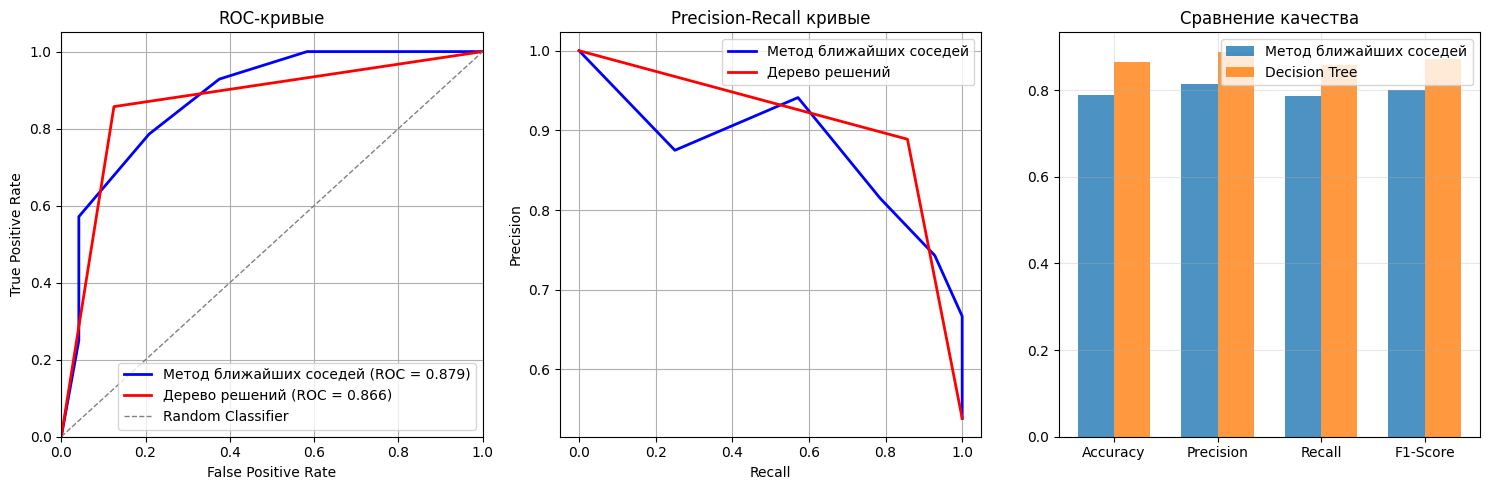

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, 
         label=f'Метод ближайших соседей (ROC = {roc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, 
         label=f'Дерево решений (ROC = {roc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 3, 2)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_proba_dt)

plt.plot(recall_knn, precision_knn, color='blue', lw=2, label='Метод ближайших соседей')
plt.plot(recall_dt, precision_dt, color='red', lw=2, label='Дерево решений')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
metrics_comparison = metrics_df.drop('Алгоритм', axis=1)
x_pos = np.arange(len(metrics_comparison.columns))
width = 0.35

plt.bar(x_pos - width/2, metrics_comparison.iloc[0], width, label='Метод ближайших соседей', alpha=0.8)
plt.bar(x_pos + width/2, metrics_comparison.iloc[1], width, label='Decision Tree', alpha=0.8)

plt.title('Сравнение качества')
plt.xticks(x_pos, metrics_comparison.columns)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Анализ результатов

В данной ситуации алгоритм "дерево решений" показал лучшие результаты чем "метод ближайших соседей". Метод ближайших соседей чувствителен к кол-ву признаков из-за "прояклятия размерности". Возможно, результаты kNN можно улучшить изменяя и пытаясь найти оптимальной кол-во соседей